In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [31]:
data = np.load("candidate_dataset.npz")

# Print the available keys in the .npz file to see what data is actually stored.
print("Available keys in candidate_dataset.npz:", data.files)

# Once you see the correct keys, uncomment and adjust the lines below:
X_train = data["x_train"]
y_train = data["y_train"]

X_val = data["x_val"]
y_val = data["y_val"]

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


Available keys in candidate_dataset.npz: ['x_train', 'y_train', 'x_val', 'y_val']
Train shape: (7007, 28, 28, 3) (7007, 1)
Val shape: (1003, 28, 28, 3) (1003, 1)


In [32]:
# Normalize
X_train = X_train / 255.0
X_val = X_val / 255.0

# The images already have 3 channels, so no need to add an extra channel dimension.
# If your images were grayscale and needed a channel dimension, it would be X_train = X_train[..., np.newaxis]
# For 3-channel images, the shape is already (batch, height, width, channels)

# One-hot encode labels
y_train_cat = to_categorical(y_train, 7)
y_val_cat = to_categorical(y_val, 7)

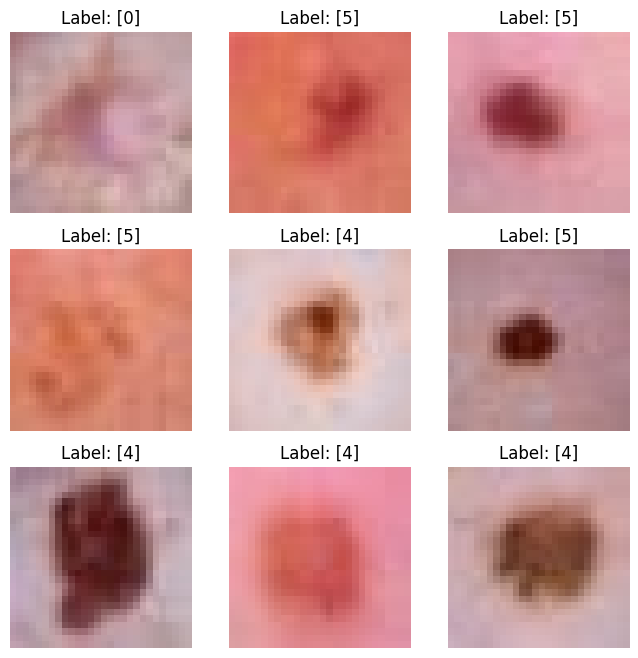

In [33]:
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].squeeze(), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.show()


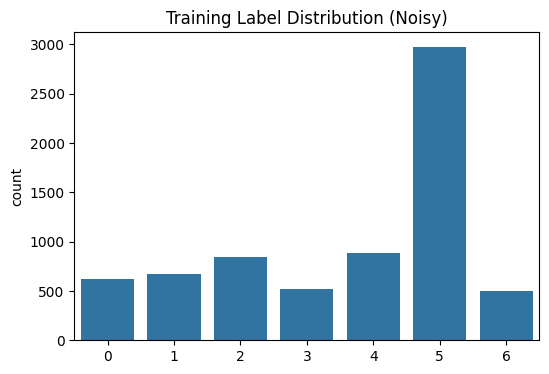

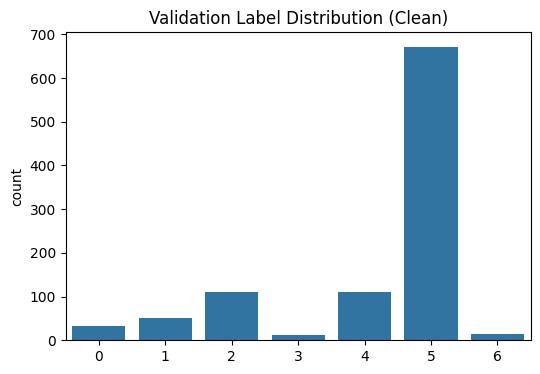

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train.squeeze())
plt.title("Training Label Distribution (Noisy)")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=y_val.squeeze())
plt.title("Validation Label Distribution (Clean)")
plt.show()

In [35]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1
)


In [36]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)), # Corrected input_shape to 3 channels
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,223 (879.78 KB)

 Trainable params: 225,223 (879.78 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]


In [39]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4184 - loss: 1.7638 - val_accuracy: 0.6690 - val_loss: 1.4045
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4327 - loss: 1.7281 - val_accuracy: 0.6690 - val_loss: 1.3504
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4260 - loss: 1.7279 - val_accuracy: 0.6690 - val_loss: 1.3967
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.4214 - loss: 1.7256 - val_accuracy: 0.6690 - val_loss: 1.2756
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4203 - loss: 1.7251 - val_accuracy: 0.6690 - val_loss: 1.2975
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4225 - loss: 1.7155 - val_accuracy: 0.6690 - val_loss: 1.3332
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4269 - loss: 1.7094 - val_accuracy: 0.6730 - val_loss: 1.3187
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4292 - loss: 1.6998 - val_accu

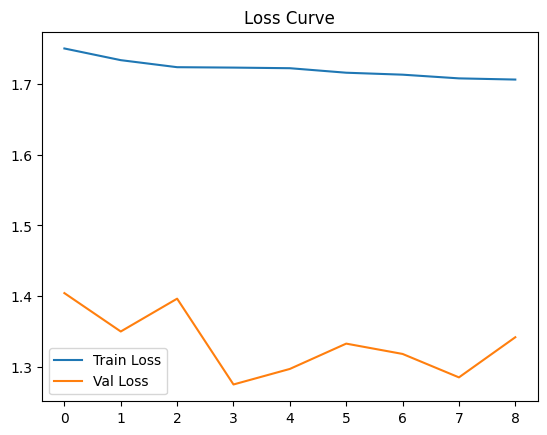

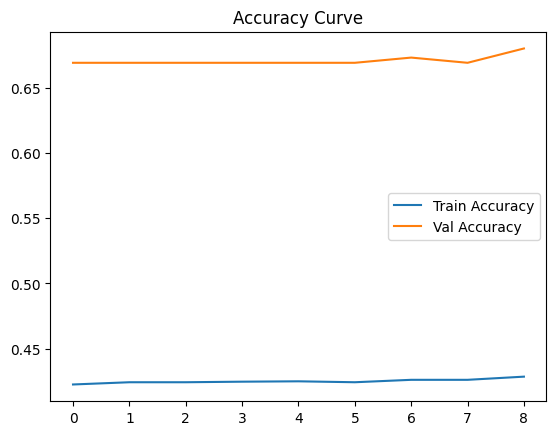

In [40]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [41]:
val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.6690


In [42]:
model.save("best_model.keras")
print("Model saved successfully.")


Model saved successfully.
